In [1]:
# imports
import pandas as pd
import os, ipdb, re
import random, evaluate
import string
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from datasets import DatasetDict, Dataset, load_dataset
import wandb
import ast
import re, os
import subprocess

from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

/nfs/home/kabenamualus/anaconda3/envs/tdm/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def calculate_fuzz_ratio(text1, text2):
    return fuzz.ratio(str(text1).strip().lower(), str(text2).strip().lower())

def view_leaderboard_distribution(dfs):

    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_train = dfs['train'].copy()
    dfs_validation = dfs['validation'].copy()

    dfs_train['leaderboard'] = dfs_train.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_train = dfs_train['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_train, labels=counts_train.index, autopct='%1.1f%%', startangle=140)
    plt.title('Train Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_validation['leaderboard'] = dfs_validation.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_validation = dfs_validation['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_validation, labels=counts_validation.index, autopct='%1.1f%%', startangle=140)
    plt.title('Validation Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_zeroshot['leaderboard'] = dfs_zeroshot.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts = dfs_zeroshot['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Zeroshot Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    
def verify_data_integrity_old(dfs):

    zeroshot_paper_in_train = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['train'].id.to_list():
            zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['validation'].id.to_list():
            zeroshot_paper_in_validation += 1 

    train_paper_in_validation = 0
    for paper in dfs['train'].id.unique():
        if paper in dfs['validation'].id.to_list():
            train_paper_in_validation += 1   
        
    validation_paper_in_zeroshot = 0
    for paper in dfs['validation'].id.unique():
        if paper in dfs['zeroshot'].id.to_list():
            validation_paper_in_zeroshot += 1     
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"train_paper_in_validation: {train_paper_in_validation}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def verify_data_integrity(dfs, include_no_lb=True):

    zeroshot_paper_in_train = 0
    dfs_train = dfs['train'].copy()
    dfs_train.drop_duplicates(subset='id', inplace=True)
    dfs_validation = dfs['validation'].copy()
    dfs_validation.drop_duplicates(subset='id', inplace=True)
    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_zeroshot.drop_duplicates(subset='id', inplace=True)
    
    records_zero_train = dfs_zeroshot.to_dict("records")    
    for row in records_zero_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                zeroshot_paper_in_train += 1
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    records_zero_val = dfs_zeroshot.to_dict("records")
    for row in records_zero_val:
        if include_no_lb:
            if row['id'] in dfs_validation['id'].to_list():
                zeroshot_paper_in_validation += 1 
        else:
            if row['id'] in dfs_validation['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_validation += 1 

    validation_paper_in_train = 0
    records_val_train = dfs_validation.to_dict("records")
    for row in records_val_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                validation_paper_in_train += 1   
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_train += 1   
        
    validation_paper_in_zeroshot = 0
    records_train_zero = dfs_validation.to_dict("records")
    for row in records_train_zero:
            
        if include_no_lb:
            if row['id'] in dfs_zeroshot['id'].to_list():
                validation_paper_in_zeroshot += 1     
        else:
            if row['id'] in dfs_zeroshot['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_zeroshot += 1   
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"validation_paper_in_train: {validation_paper_in_train}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def remove_data_leakage_old(dfs, source, target, THRESHOLD=90):
    papers_to_drop = []
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    source_records = dfs[source].to_dict("records")

    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        
        for leaderboard_source in source_tdms:
            
            if to_drop_paper_found:
                break
            
            source_task = leaderboard_source["LEADERBOARD"]["Task"]
            source_dataset = leaderboard_source["LEADERBOARD"]["Dataset"]
            source_metric = leaderboard_source["LEADERBOARD"]["Metric"]
            source_score = leaderboard_source["LEADERBOARD"]["Score"]
 
            dfs[target].drop_duplicates(subset='id', inplace=True)
            
            target_records = dfs[target].to_dict("records")

            for target_row in target_records:
                
                if to_drop_paper_found:
                        break    
                
                target_paper_id = target_row["id"]
                target_tdms = target_row["answer"]
                
                if target_tdms == "unanswerable" or target_tdms == "missed":
                    # ipdb.set_trace()
                    continue 
                
                target_tdms = ast.literal_eval(target_row["answer"])
                
                
                for leaderboard_target in target_tdms:
                    target_task = leaderboard_target["LEADERBOARD"]["Task"]
                    target_dataset = leaderboard_target["LEADERBOARD"]["Dataset"]
                    target_metric = leaderboard_target["LEADERBOARD"]["Metric"]
                    target_score = leaderboard_target["LEADERBOARD"]["Score"]
                    
                    # A) Exact 
                    if (source_task == target_task and source_dataset == target_dataset and source_metric == target_metric) or (target_paper_id == source_paper_id):
                        if source_paper_id not in papers_to_drop:
                            papers_to_drop.append(source_paper_id)
                        to_drop_paper_found = True 
                        break
    
                    # # B) Partial  or # A) Exact 
                    # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
                    #     if paper_id not in papers_to_drop:
                    #         papers_to_drop.append(paper_id)
                    #         # ipdb.set_trace()
                    #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage_id(dfs, source, target, THRESHOLD=90):
    papers_to_drop = set()
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    records = dfs[source].to_dict("records")

    for row in tqdm(records, total=len(records)):
        to_drop_paper_found = False 
        source_paper_id = row["id"]
        
        dfs[target].drop_duplicates(subset='id', inplace=True)
        target_records = dfs[target].to_dict("records")

        for row_target in target_records:  
            
            target_paper_id = row_target["id"]
            
            # A) Exact 
            if (target_paper_id == source_paper_id):
                papers_to_drop.add(source_paper_id)
                to_drop_paper_found = True 
                break
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage(dfs, source, target, THRESHOLD=90):
    papers_to_drop = {"id": set(), "tdm":set()}
    missed_parsing_zero = 0
    
    dfs_target = dfs[target].drop_duplicates(subset='id')
    unique_paper_id_target = dfs_target.id.unique()
    lists_target = [ast.literal_eval(lb) for lb in dfs_target[dfs_target.leaderboard =="lb"].answer.to_list()]
    # Flatten the list of lists
    flattened_list_target = [item for sublist in lists_target for item in sublist]
    # Extract unique tuples
    unique_tuples_target = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in flattened_list_target}


    dfs_source = dfs[source].drop_duplicates(subset='id')
    source_records = dfs_source.to_dict("records")
    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_paper_id in unique_paper_id_target:
            papers_to_drop["id"].add(source_paper_id)
            continue     
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        # Extract unique tuples
        unique_tuples_source = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in source_tdms} 
        
        is_contained = unique_tuples_source.issubset(unique_tuples_target)
    
        if is_contained:
            papers_to_drop["tdm"].add(source_paper_id)
            
      
        
        # # B) Partial  or # A) Exact 
        # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
        #     if paper_id not in papers_to_drop:
        #         papers_to_drop.append(paper_id)
        #         # ipdb.set_trace()
        #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target} Title ID: {len(papers_to_drop['id'])}") 
    print(f"Lenght papers_to_drop in {source} based on {target} TDM Match: {len(papers_to_drop['tdm'])}")   

    print(f"Lenght papers from {source} with lb: {len(dfs_source[dfs_source['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {source} with no_lb: {len(dfs_source[dfs_source['leaderboard']=='no_lb'])}") 
    print(f"Lenght papers from {target} with lb: {len(dfs_target[dfs_target['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {target} with no_lb: {len(dfs_target[dfs_target['leaderboard']=='no_lb'])}") 
    
    
    return papers_to_drop

# No Templates

## DOCTEAT

### STRICT

In [4]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_NO_TEMPLATE_DOCTEAT/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT/fold1"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")

In [5]:
dfs['train'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,150870,150870,150870,150870,150870
unique,10058,10004,7016,1,2
top,1707.03497v2.pdf,Author Guidelines for ECCV Submission The abst...,unanswerable,drop_3,lb
freq,15,105,45495,150870,105375


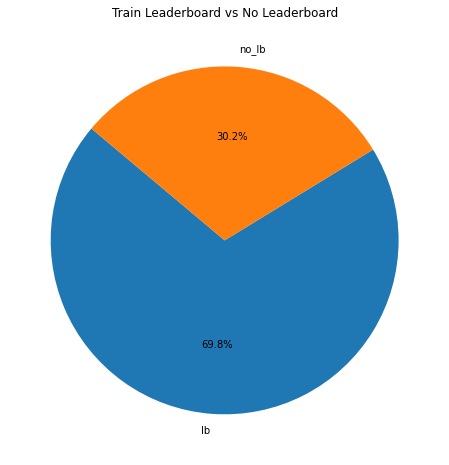

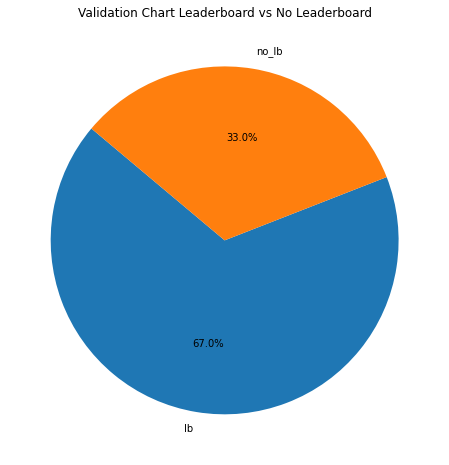

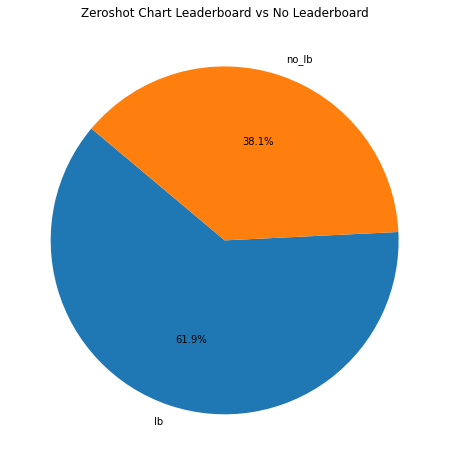

In [6]:
view_leaderboard_distribution(dfs)

In [7]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 926/926 [00:00<00:00, 5799.68it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8108.81it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [8]:
print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

len(dfs['zeroshot']): 13890
len(dfs['validation']): 20205
len(dfs['zeroshot']): 6120
len(dfs['validation']): 20205


In [9]:
# In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
# At least one of the leaderboard was not seen at training time 
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

print("\nvalidation\n")
# in validation this means paper to keep as part of few shot 
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 408/408 [00:00<00:00, 10681.86it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8136.64it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [10]:
zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
print(f"len(zeroshot_concat): {len(zeroshot_concat)}")
# zeroshot_concat = dfs['zeroshot']
# print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
print(f"len(validation_concat): {len(validation_concat)}")

len(zeroshot_concat): 9750
len(validation_concat): 20865


In [11]:
# Filtering the DataFrame
dfs['zeroshot'] = zeroshot_concat.copy()

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]

# dfs.loc[condition, 'column_to_modify'] = new_value
# dfs['zeroshot'] = dfs['zeroshot'].loc[~(dfs['zeroshot'].loc['id'].isin(zeroshot_papers_to_drop['tdm'])), :]

dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_3,no_lb
freq,1,1,353,595,353


In [12]:
# Filtering the DataFrame
dfs['validation'] = validation_concat.copy()
# I want to keep all the no leaderboard papers in validation 
dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]
dfs['validation'].drop_duplicates(subset='id', inplace=True)
dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,1105,1105,1105,1105,1105
unique,1105,1105,661,1,2
top,1810.02575v1.pdf,Dark Model Adaptation: Semantic Image Segmenta...,unanswerable,drop_3,lb
freq,1,1,444,1105,661


In [13]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 595/595 [00:00<00:00, 8986.07it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8575.82it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [14]:
# Filtering the DataFrame
dfs['train'].drop_duplicates(subset='id', inplace=True)
dfs['train'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,10058,10058,10058,10058,10058
unique,10058,10004,7016,1,2
top,1707.03497v2.pdf,Author Guidelines for ECCV Submission The abst...,unanswerable,drop_3,lb
freq,1,7,3033,10058,7025


In [15]:
dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

In [16]:
dfs['train'].tail()

,id,prompt,answer,template,prompt lenght,leaderboard
150795,1401.6576.pdf,Adding modular predicates to first-order fragm...,unanswerable,drop_3,206,no_lb
150810,1304.4691.pdf,Efficient Calculation of Determinants of Symbo...,unanswerable,drop_3,128,no_lb
150825,1001.3388.pdf,Approximate Privacy: PARs for Set Problems In ...,unanswerable,drop_3,183,no_lb
150840,0706.2010.pdf,Information-theoretic securitywithout an hones...,unanswerable,drop_3,131,no_lb
150855,1111.2942.pdf,Down the Rabbit Hole: Robust Proximity Search ...,unanswerable,drop_3,232,no_lb


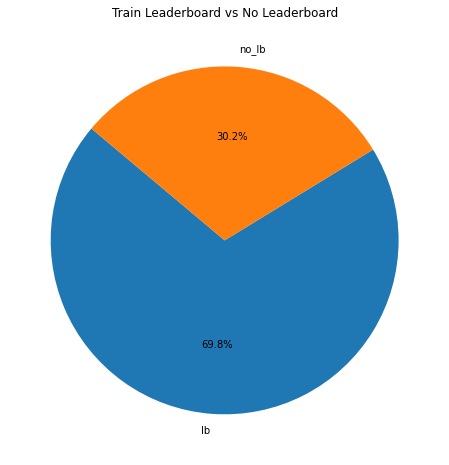

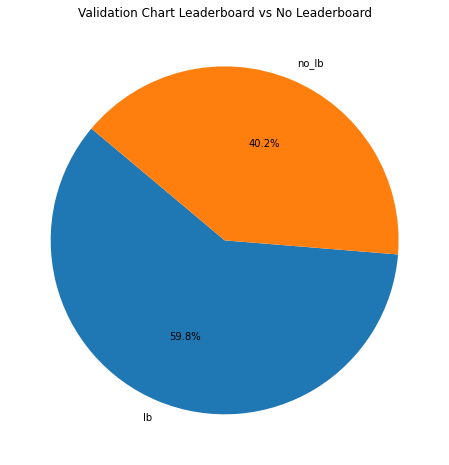

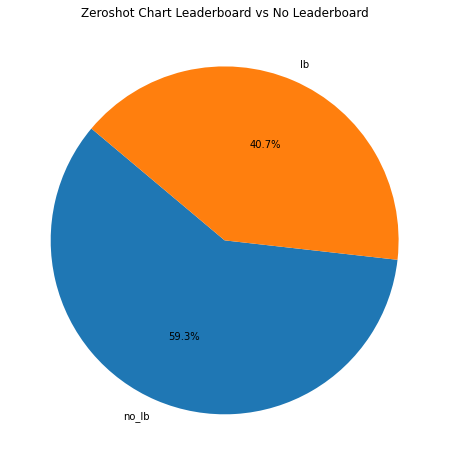

In [17]:
view_leaderboard_distribution(dfs)

In [18]:
verify_data_integrity(dfs)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 353
validation_paper_in_train: 0
validation_paper_in_zeroshot: 353


In [19]:
# no leaderboard paper can be shared between few-shot and zero-shot
verify_data_integrity(dfs, include_no_lb=False)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


In [20]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_STRICT")

Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

### Template Specific

In [22]:
for squad_id in range(1, 9):
    print(f"SQUAD: {squad_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_SQUAD_{squad_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")

    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")
    
    # In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
    # At least one of the leaderboard was not seen at training time 
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    # in validation this means paper to keep as part of few shot 
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
    print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

    validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
    print(f"len(validation_concat): {len(validation_concat)}")
    
    # Filtering the DataFrame
    dfs['zeroshot'] = zeroshot_concat.copy()
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    # Filtering the DataFrame
    dfs['validation'] = validation_concat.copy()
    # I want to keep all the no leaderboard papers in validation 
    dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]
    dfs['validation'].drop_duplicates(subset='id', inplace=True)
    dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

    # no leaderboard paper can be shared between few-shot and zero-shot
    verify_data_integrity(dfs, include_no_lb=False)
    
    display(dfs['zeroshot'].drop(["prompt lenght"], axis=1).describe())
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_SQUAD_{squad_id}_STRICT")

SQUAD: 1

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5868.06it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8150.67it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10623.50it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8160.78it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9033.26it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8560.39it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_1,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

SQUAD: 2

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11688.50it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8038.69it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10597.25it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8135.89it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8969.63it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8718.16it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this and answer the question. If the ques...,unanswerable,squad_2,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

SQUAD: 3

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5902.07it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8064.79it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10624.36it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8088.99it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8927.08it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8576.83it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_3,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

SQUAD: 4

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11650.91it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7988.57it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10841.02it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8015.23it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8963.31it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8526.17it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_4,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

SQUAD: 5

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5886.81it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 5667.13it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10844.52it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8081.64it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8980.93it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8541.91it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_5,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

SQUAD: 6

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5843.64it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 5605.42it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10667.61it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8011.42it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8948.95it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8450.89it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_6,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

SQUAD: 7

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5858.77it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7914.35it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10640.61it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8122.17it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9043.44it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8544.45it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this: SharinGAN: Combining Synthetic and ...,unanswerable,squad_7,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

SQUAD: 8

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11683.40it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8032.87it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10620.67it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8059.39it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8948.53it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8589.25it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this: SharinGAN: Combining Synthetic and ...,unanswerable,squad_8,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

In [23]:
for drop_id in range(1, 8):
    print(f"DROP: {drop_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_DROP_{drop_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")

    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")
    
    # In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
    # At least one of the leaderboard was not seen at training time 
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    # in validation this means paper to keep as part of few shot 
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
    print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

    validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
    print(f"len(validation_concat): {len(validation_concat)}")
    
    # Filtering the DataFrame
    dfs['zeroshot'] = zeroshot_concat.copy()
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    # Filtering the DataFrame
    dfs['validation'] = validation_concat.copy()
    # I want to keep all the no leaderboard papers in validation 
    dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]
    dfs['validation'].drop_duplicates(subset='id', inplace=True)
    dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

    # no leaderboard paper can be shared between few-shot and zero-shot
    verify_data_integrity(dfs, include_no_lb=False)
    
    display(dfs['zeroshot'].drop(["prompt lenght"], axis=1).describe())
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_DROP_{drop_id}_STRICT")

DROP: 1



Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11699.24it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7988.70it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10652.93it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8022.98it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8946.77it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8516.78it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,Answer based on context:\n\nSharinGAN: Combini...,unanswerable,drop_1,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

DROP: 2

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5914.78it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 6266.08it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10716.77it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8068.40it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8987.82it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8505.56it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_2,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

DROP: 3

Zeroshot



100%|██████████| 924/924 [00:00<00:00, 11734.63it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 517
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 572
Lenght papers from zeroshot with no_lb: 352
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032

validation



100%|██████████| 1344/1344 [00:00<00:00, 8150.97it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 659
Lenght papers from validation with lb: 901
Lenght papers from validation with no_lb: 443
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032
len(dfs['zeroshot']): 924
len(dfs['validation']): 1344
len(dfs['zeroshot']): 407
len(dfs['validation']): 1344

Zeroshot



100%|██████████| 407/407 [00:00<00:00, 10707.67it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 352
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032

validation



100%|██████████| 1344/1344 [00:00<00:00, 8109.46it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 659
Lenght papers from validation with lb: 901
Lenght papers from validation with no_lb: 443
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032
len(zeroshot_concat): 649
len(validation_concat): 1388

Zeroshot



100%|██████████| 594/594 [00:00<00:00, 8985.72it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 352
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032

validation



100%|██████████| 1102/1102 [00:00<00:00, 8581.83it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 659
Lenght papers from validation with lb: 659
Lenght papers from validation with no_lb: 443
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,594,594,594,594,594
unique,594,594,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_3,no_lb
freq,1,1,352,594,352


Saving the dataset (0/1 shards):   0%|          | 0/10051 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1102 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/594 [00:00<?, ? examples/s]

DROP: 4

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11960.96it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8039.56it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10733.38it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8104.35it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9031.04it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8590.42it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_4,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

DROP: 5

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11674.55it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8089.78it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10643.65it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8182.92it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9027.84it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8695.33it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this article and answer this question Sha...,unanswerable,drop_5,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

DROP: 6

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5861.23it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 6182.74it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10661.69it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8082.63it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9041.84it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8580.61it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_6,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

DROP: 7

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11958.05it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8041.25it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 928
len(dfs['validation']): 1350
len(dfs['zeroshot']): 409
len(dfs['validation']): 1350

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10703.70it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8037.79it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 651
len(validation_concat): 1394

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9003.74it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8570.50it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,595,595,595,595,595
unique,595,595,243,1,2
top,2006.04026v1.pdf,Context: SharinGAN: Combining Synthetic and Re...,unanswerable,drop_7,no_lb
freq,1,1,353,595,353


Saving the dataset (0/1 shards):   0%|          | 0/10065 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1105 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/595 [00:00<?, ? examples/s]

## DOCTEAT

### RELAX

In [20]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_NO_TEMPLATE_DOCTEAT/fold1"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

In [21]:
dfs['train'].describe()

,prompt lenght,__index_level_0__
count,150870.000000,150870.000000
mean,485.707298,75434.500000
std,398.720864,43552.561894
min,27.000000,0.000000
25%,216.000000,37717.250000
50%,392.000000,75434.500000
75%,640.000000,113151.750000
max,7344.000000,150869.000000


In [22]:
dfs['validation'].describe()

,prompt lenght,__index_level_0__
count,20205.000000,20205.00000
mean,473.135857,10102.00000
std,352.229574,5832.82543
min,26.000000,0.00000
25%,222.000000,5051.00000
50%,387.000000,10102.00000
75%,614.000000,15153.00000
max,3431.000000,20204.00000


In [23]:
dfs['zeroshot'].describe()

,prompt lenght,__index_level_0__
count,13890.000000,13890.000000
mean,444.615551,6944.500000
std,405.101173,4009.841954
min,29.000000,0.000000
25%,199.000000,3472.250000
50%,342.000000,6944.500000
75%,582.000000,10416.750000
max,7344.000000,13889.000000


In [24]:
zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

  0%|          | 0/926 [00:00<?, ?it/s]

100%|██████████| 926/926 [09:12<00:00,  1.68it/s] 

Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


In [25]:
# validation_papers_to_drop_no_lb = remove_data_leakage(dfs, source="validation", target="zeroshot", THRESHOLD=90)

records = dfs['zeroshot'].to_dict("records")
validation_papers_to_drop_no_lb = set()
for row in tqdm(records, total=len(records)):
    # if row['id'] in dfs['train']['id'].to_list():
    #     duplicate+=1
    if row['id'] in dfs['validation']['id'].to_list():
        validation_papers_to_drop_no_lb.add(row['id'])
        
print(len(validation_papers_to_drop_no_lb))

100%|██████████| 926/926 [00:00<00:00, 3200.91it/s]

408


In [26]:
# Filtering the DataFrame
dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
dfs['zeroshot'].describe()

,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,197.560907,11235.00000
std,99.668184,1530.69837
min,29.000000,8595.00000
25%,138.000000,9915.00000
50%,192.000000,11235.00000
75%,234.000000,12555.00000
max,677.000000,13875.00000


In [27]:
# Filtering the DataFrame
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
dfs['validation'].describe()

,prompt lenght,__index_level_0__
count,14085.000000,14085.000000
mean,568.654952,7441.408946
std,357.924884,4298.798394
min,26.000000,0.000000
25%,325.000000,3716.000000
50%,497.000000,7432.000000
75%,709.000000,11148.000000
max,3431.000000,14909.000000


In [28]:
# Filtering the DataFrame
dfs['train'].describe()

,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,485.707298,75427.500000
std,398.739365,43554.582566
min,27.000000,0.000000
25%,216.000000,37713.750000
50%,392.000000,75427.500000
75%,640.000000,113141.250000
max,7344.000000,150855.000000


In [29]:
dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

In [30]:
dfs['train'].tail()

,id,prompt,answer,prompt lenght
150795,1401.6576.pdf,Adding modular predicates to first-order fragm...,unanswerable,206
150810,1304.4691.pdf,Efficient Calculation of Determinants of Symbo...,unanswerable,128
150825,1001.3388.pdf,Approximate Privacy: PARs for Set Problems In ...,unanswerable,183
150840,0706.2010.pdf,Information-theoretic securitywithout an hones...,unanswerable,131
150855,1111.2942.pdf,Down the Rabbit Hole: Robust Proximity Search ...,unanswerable,232


In [31]:
dfs['train'].id.nunique()

10058

In [32]:
verify_data_integrity(dfs)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


In [33]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_RELAX")

Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14085 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

### Templates Specific

In [34]:
for squad_id in range(1, 9):
    print(f"SQUAD: {squad_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_SQUAD_{squad_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    
    zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    
    records = dfs['zeroshot'].to_dict("records")
    validation_papers_to_drop_no_lb = set()
    for row in tqdm(records, total=len(records)):
        # if row['id'] in dfs['train']['id'].to_list():
        #     duplicate+=1
        if row['id'] in dfs['validation']['id'].to_list():
            validation_papers_to_drop_no_lb.add(row['id'])
            
    print(len(validation_papers_to_drop_no_lb))
    
    # Filtering the DataFrame
    display(dfs['train'].describe())

    # Filtering the DataFrame
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
    display(dfs['validation'].describe())

    # Filtering the DataFrame
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
    display(dfs['zeroshot'].describe())
    
    dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

    verify_data_integrity(dfs)
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_SQUAD_{squad_id}_RELAX")

SQUAD: 1


  0%|          | 0/926 [00:00<?, ?it/s]

100%|██████████| 926/926 [09:13<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 74059.94it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,498.707298,75427.500000
std,398.739365,43554.582566
min,40.000000,0.000000
25%,229.000000,37713.750000
50%,405.000000,75427.500000
75%,653.000000,113141.250000
max,7357.000000,150855.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,581.654952,7434.408946
std,358.102912,4300.934395
min,39.000000,0.000000
25%,338.000000,3712.500000
50%,510.000000,7425.000000
75%,720.500000,11137.500000
max,3444.000000,14895.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,210.560907,11235.00000
std,99.668184,1530.69837
min,42.000000,8595.00000
25%,151.000000,9915.00000
50%,205.000000,11235.00000
75%,247.000000,12555.00000
max,690.000000,13875.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

SQUAD: 2


100%|██████████| 926/926 [09:12<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 73973.90it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,497.707298,75428.500000
std,398.739365,43554.582566
min,39.000000,1.000000
25%,228.000000,37714.750000
50%,404.000000,75428.500000
75%,652.000000,113142.250000
max,7356.000000,150856.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,580.654952,7435.408946
std,358.102912,4300.934395
min,38.000000,1.000000
25%,337.000000,3713.500000
50%,509.000000,7426.000000
75%,719.500000,11138.500000
max,3443.000000,14896.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,209.560907,11236.00000
std,99.668184,1530.69837
min,41.000000,8596.00000
25%,150.000000,9916.00000
50%,204.000000,11236.00000
75%,246.000000,12556.00000
max,689.000000,13876.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

SQUAD: 3


100%|██████████| 926/926 [09:13<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77535.84it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,491.707298,75429.500000
std,398.739365,43554.582566
min,33.000000,2.000000
25%,222.000000,37715.750000
50%,398.000000,75429.500000
75%,646.000000,113143.250000
max,7350.000000,150857.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,574.654952,7436.408946
std,358.102912,4300.934395
min,32.000000,2.000000
25%,331.000000,3714.500000
50%,503.000000,7427.000000
75%,713.500000,11139.500000
max,3437.000000,14897.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,203.560907,11237.00000
std,99.668184,1530.69837
min,35.000000,8597.00000
25%,144.000000,9917.00000
50%,198.000000,11237.00000
75%,240.000000,12557.00000
max,683.000000,13877.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

SQUAD: 4


100%|██████████| 926/926 [09:13<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77882.56it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,494.707298,75430.500000
std,398.739365,43554.582566
min,36.000000,3.000000
25%,225.000000,37716.750000
50%,401.000000,75430.500000
75%,649.000000,113144.250000
max,7353.000000,150858.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,577.654952,7437.408946
std,358.102912,4300.934395
min,35.000000,3.000000
25%,334.000000,3715.500000
50%,506.000000,7428.000000
75%,716.500000,11140.500000
max,3440.000000,14898.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,206.560907,11238.00000
std,99.668184,1530.69837
min,38.000000,8598.00000
25%,147.000000,9918.00000
50%,201.000000,11238.00000
75%,243.000000,12558.00000
max,686.000000,13878.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

SQUAD: 5


100%|██████████| 926/926 [09:15<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 73070.67it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,499.707298,75431.500000
std,398.739365,43554.582566
min,41.000000,4.000000
25%,230.000000,37717.750000
50%,406.000000,75431.500000
75%,654.000000,113145.250000
max,7358.000000,150859.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,582.654952,7438.408946
std,358.102912,4300.934395
min,40.000000,4.000000
25%,339.000000,3716.500000
50%,511.000000,7429.000000
75%,721.500000,11141.500000
max,3445.000000,14899.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,211.560907,11239.00000
std,99.668184,1530.69837
min,43.000000,8599.00000
25%,152.000000,9919.00000
50%,206.000000,11239.00000
75%,248.000000,12559.00000
max,691.000000,13879.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

SQUAD: 6


100%|██████████| 926/926 [09:11<00:00,  1.68it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 74397.58it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,493.707298,75432.500000
std,398.739365,43554.582566
min,35.000000,5.000000
25%,224.000000,37718.750000
50%,400.000000,75432.500000
75%,648.000000,113146.250000
max,7352.000000,150860.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,576.654952,7439.408946
std,358.102912,4300.934395
min,34.000000,5.000000
25%,333.000000,3717.500000
50%,505.000000,7430.000000
75%,715.500000,11142.500000
max,3439.000000,14900.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,205.560907,11240.00000
std,99.668184,1530.69837
min,37.000000,8600.00000
25%,146.000000,9920.00000
50%,200.000000,11240.00000
75%,242.000000,12560.00000
max,685.000000,13880.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

SQUAD: 7


100%|██████████| 926/926 [09:13<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 75894.98it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,497.707298,75433.500000
std,398.739365,43554.582566
min,39.000000,6.000000
25%,228.000000,37719.750000
50%,404.000000,75433.500000
75%,652.000000,113147.250000
max,7356.000000,150861.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,580.654952,7440.408946
std,358.102912,4300.934395
min,38.000000,6.000000
25%,337.000000,3718.500000
50%,509.000000,7431.000000
75%,719.500000,11143.500000
max,3443.000000,14901.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,209.560907,11241.00000
std,99.668184,1530.69837
min,41.000000,8601.00000
25%,150.000000,9921.00000
50%,204.000000,11241.00000
75%,246.000000,12561.00000
max,689.000000,13881.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

SQUAD: 8


100%|██████████| 926/926 [09:12<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 73921.80it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,502.707298,75434.500000
std,398.739365,43554.582566
min,44.000000,7.000000
25%,233.000000,37720.750000
50%,409.000000,75434.500000
75%,657.000000,113148.250000
max,7361.000000,150862.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,585.654952,7441.408946
std,358.102912,4300.934395
min,43.000000,7.000000
25%,342.000000,3719.500000
50%,514.000000,7432.000000
75%,724.500000,11144.500000
max,3448.000000,14902.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,214.560907,11242.00000
std,99.668184,1530.69837
min,46.000000,8602.00000
25%,155.000000,9922.00000
50%,209.000000,11242.00000
75%,251.000000,12562.00000
max,694.000000,13882.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

In [35]:
for drop_id in range(1, 8):
    print(f"DROP: {drop_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_DROP_{drop_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    
    zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    records = dfs['zeroshot'].to_dict("records")
    validation_papers_to_drop_no_lb = set()
    for row in tqdm(records, total=len(records)):
        # if row['id'] in dfs['train']['id'].to_list():
        #     duplicate+=1
        if row['id'] in dfs['validation']['id'].to_list():
            validation_papers_to_drop_no_lb.add(row['id'])
            
    print(len(validation_papers_to_drop_no_lb))
    
    # Filtering the DataFrame
    display(dfs['train'].describe())

    # Filtering the DataFrame
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
    display(dfs['validation'].describe())

    # Filtering the DataFrame
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
    display(dfs['zeroshot'].describe())
    
    dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

    verify_data_integrity(dfs)
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_DROP_{drop_id}_RELAX")

DROP: 1


100%|██████████| 926/926 [09:16<00:00,  1.66it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77881.00it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,488.707298,75435.500000
std,398.739365,43554.582566
min,30.000000,8.000000
25%,219.000000,37721.750000
50%,395.000000,75435.500000
75%,643.000000,113149.250000
max,7347.000000,150863.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,571.654952,7442.408946
std,358.102912,4300.934395
min,29.000000,8.000000
25%,328.000000,3720.500000
50%,500.000000,7433.000000
75%,710.500000,11145.500000
max,3434.000000,14903.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,200.560907,11243.00000
std,99.668184,1530.69837
min,32.000000,8603.00000
25%,141.000000,9923.00000
50%,195.000000,11243.00000
75%,237.000000,12563.00000
max,680.000000,13883.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

DROP: 2


100%|██████████| 926/926 [09:11<00:00,  1.68it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 78145.82it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,491.707298,75436.500000
std,398.739365,43554.582566
min,33.000000,9.000000
25%,222.000000,37722.750000
50%,398.000000,75436.500000
75%,646.000000,113150.250000
max,7350.000000,150864.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,574.654952,7443.408946
std,358.102912,4300.934395
min,32.000000,9.000000
25%,331.000000,3721.500000
50%,503.000000,7434.000000
75%,713.500000,11146.500000
max,3437.000000,14904.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,203.560907,11244.00000
std,99.668184,1530.69837
min,35.000000,8604.00000
25%,144.000000,9924.00000
50%,198.000000,11244.00000
75%,240.000000,12564.00000
max,683.000000,13884.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

DROP: 3


100%|██████████| 924/924 [09:15<00:00,  1.66it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 572


100%|██████████| 924/924 [00:00<00:00, 72919.71it/s]

407


,prompt lenght,__index_level_0__
count,10051.000000,10051.000000
mean,484.701622,75455.098995
std,398.858367,43559.044436
min,26.000000,10.000000
25%,215.000000,37742.500000
50%,391.000000,75475.000000
75%,639.500000,113177.500000
max,7343.000000,150865.000000


,prompt lenght,__index_level_0__
count,937.000000,937.000000
mean,567.586980,7445.021345
std,358.481939,4304.324351
min,25.000000,10.000000
25%,324.000000,3715.000000
50%,495.000000,7435.000000
75%,708.000000,11155.000000
max,3430.000000,14905.000000


,prompt lenght,__index_level_0__
count,352.000000,352.000000
mean,196.417614,11240.951705
std,99.773641,1530.983713
min,28.000000,8605.000000
25%,137.000000,9921.250000
50%,191.000000,11237.500000
75%,233.000000,12553.750000
max,676.000000,13885.000000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10051 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/937 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/352 [00:00<?, ? examples/s]

DROP: 4


100%|██████████| 926/926 [09:12<00:00,  1.68it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77138.54it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,487.707298,75438.500000
std,398.739365,43554.582566
min,29.000000,11.000000
25%,218.000000,37724.750000
50%,394.000000,75438.500000
75%,642.000000,113152.250000
max,7346.000000,150866.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,570.654952,7445.408946
std,358.102912,4300.934395
min,28.000000,11.000000
25%,327.000000,3723.500000
50%,499.000000,7436.000000
75%,709.500000,11148.500000
max,3433.000000,14906.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,199.560907,11246.00000
std,99.668184,1530.69837
min,31.000000,8606.00000
25%,140.000000,9926.00000
50%,194.000000,11246.00000
75%,236.000000,12566.00000
max,679.000000,13886.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

DROP: 5


100%|██████████| 926/926 [09:15<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 75822.38it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,491.707298,75439.500000
std,398.739365,43554.582566
min,33.000000,12.000000
25%,222.000000,37725.750000
50%,398.000000,75439.500000
75%,646.000000,113153.250000
max,7350.000000,150867.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,574.654952,7446.408946
std,358.102912,4300.934395
min,32.000000,12.000000
25%,331.000000,3724.500000
50%,503.000000,7437.000000
75%,713.500000,11149.500000
max,3437.000000,14907.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,203.560907,11247.00000
std,99.668184,1530.69837
min,35.000000,8607.00000
25%,144.000000,9927.00000
50%,198.000000,11247.00000
75%,240.000000,12567.00000
max,683.000000,13887.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

DROP: 6


100%|██████████| 926/926 [09:14<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77846.66it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,492.707298,75440.500000
std,398.739365,43554.582566
min,34.000000,13.000000
25%,223.000000,37726.750000
50%,399.000000,75440.500000
75%,647.000000,113154.250000
max,7351.000000,150868.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,575.654952,7447.408946
std,358.102912,4300.934395
min,33.000000,13.000000
25%,332.000000,3725.500000
50%,504.000000,7438.000000
75%,714.500000,11150.500000
max,3438.000000,14908.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,204.560907,11248.00000
std,99.668184,1530.69837
min,36.000000,8608.00000
25%,145.000000,9928.00000
50%,199.000000,11248.00000
75%,241.000000,12568.00000
max,684.000000,13888.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

DROP: 7


100%|██████████| 926/926 [09:13<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77610.21it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,487.707298,75441.497216
std,398.739365,43554.584181
min,29.000000,14.000000
25%,218.000000,37727.750000
50%,394.000000,75441.500000
75%,642.000000,113155.250000
max,7346.000000,150869.000000


,prompt lenght,__index_level_0__
count,941.000000,941.000000
mean,570.722635,7447.790648
std,357.725086,4297.556692
min,28.000000,14.000000
25%,327.000000,3734.000000
50%,499.000000,7439.000000
75%,708.000000,11144.000000
max,3433.000000,14909.000000


,prompt lenght,__index_level_0__
count,353.000000,353.000000
mean,199.560907,11248.988669
std,99.668184,1530.687806
min,31.000000,8609.000000
25%,140.000000,9929.000000
50%,194.000000,11249.000000
75%,236.000000,12569.000000
max,679.000000,13889.000000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/941 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]